In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Example to solve system of equations

In [2]:
import numpy as np

#define left-hand side of equation
left_side = np.array([[110,0.010536942, -267.3097618,145.8795169],
                      [0.010536942, 1.0138E-06,-0.025573291,0.01429025], 
                      [-267.3097618, -0.025573291,812.8222668,-264.9366099],
                      [145.8795169, 0.01429025, -264.9366099,275.5141434]])

#define right-hand side of equation
right_side = np.array([2133.709916,0.204653354,-5170.45505,2860.664942])

#solve for w, x, y, and z
np.linalg.inv(left_side).dot(right_side)

array([ 1.55579655e+01,  3.05363045e+04, -1.46901827e-01,  4.20251956e-01])

### Example data to re-create the problem

In [3]:
force1=pd.read_excel('ForceData_1.xlsx')

In [4]:
force1.head()

,Product Thickness,Pass Number,Core Temp (F),Core Temp (K),Strain,Strain Rate,Flow Stress (Pa),Meas FS (ksi),ln(FS),1/RT,ln(Strain),ln(Strain Rate)
0,0.500,1,2005.255315,1369.402953,0.028857,0.852749,1.891260e+07,2.743040,16.755339,0.000088,-3.545403,-0.159291
1,0.625,6,1933.607740,1329.598745,0.038766,2.005702,1.635305e+08,23.718087,18.912510,0.000090,-3.250216,0.695994
2,1.000,4,1933.410319,1329.489066,0.004323,0.571701,1.253132e+08,18.175144,18.646327,0.000090,-5.443858,-0.559139
3,0.375,2,1928.884342,1326.974634,0.130460,2.480761,1.291659e+08,18.733925,18.676608,0.000091,-2.036691,0.908566
4,1.000,5,1925.099331,1324.871850,0.032533,1.479811,1.403631e+08,20.357943,18.759743,0.000091,-3.425496,0.391914


In [5]:
force1.columns

Index(['Product Thickness', 'Pass Number', 'Core Temp (F)', 'Core Temp (K)',
       'Strain', 'Strain Rate', 'Flow Stress (Pa)', 'Meas FS (ksi)', 'ln(FS)',
       '1/RT', 'ln(Strain)', 'ln(Strain Rate)'],
      dtype='object')

### Form the system of equations as governed by the Zener-Holloman equation

$\sigma = Ae^{\Lambda/RT} \epsilon^{m} \epsilon'^{n}$

where, 

$\sigma =$ Force

$A =$ material base hardness

$\Lambda =$ activation energy

$R =$ Gas constant 8.31432

$T =$ Core Temperature

$\epsilon =$ Strain

$\epsilon' =$ Strain Rate

We linearize it as:

$ln(\sigma) = ln(A) + \Lambda/RT + m*ln(\epsilon) + n*ln(\epsilon')$

In [6]:
#define left-hand side of equation
left_side = np.array([[len(force1), force1['1/RT'].sum(), force1['ln(Strain)'].sum(),force1['ln(Strain Rate)'].sum()],
                     [force1['1/RT'].sum(), (np.power(force1['1/RT'],2)).sum(),(force1['1/RT']*force1['ln(Strain)']).sum(),(force1['1/RT']*force1['ln(Strain Rate)']).sum()], 
                      [force1['ln(Strain)'].sum(), (force1['1/RT']*force1['ln(Strain)']).sum(),(np.power(force1['ln(Strain)'],2)).sum(),(force1['ln(Strain)']*force1['ln(Strain Rate)']).sum()],
                      [force1['ln(Strain Rate)'].sum(), (force1['1/RT']*force1['ln(Strain Rate)']).sum(), (force1['ln(Strain)']*force1['ln(Strain Rate)']).sum(),(np.power(force1['ln(Strain Rate)'],2)).sum()]])

#define right-hand side of equation
#right_side = np.array([2133.709916,0.204653354,-5170.45505,2860.664942])
right_side = np.array([force1['ln(FS)'].sum(),(force1['ln(FS)']*force1['1/RT']).sum(),(force1['ln(FS)']*force1['ln(Strain)']).sum(),(force1['ln(FS)']*force1['ln(Strain Rate)']).sum()])

#solve for c1,c2,c3,c4
sol=np.linalg.inv(left_side).dot(right_side)

#### Checking the values below to make sure they are correct

In [7]:
force1['1/RT'].sum()*force1['ln(Strain)'].sum()

-2.816627397794231

In [8]:
(force1['1/RT']*force1['ln(Strain)']).sum()

-0.0255732905207855

In [9]:
force1['ln(FS)'].sum()

2133.709916346965

In [10]:
(force1['ln(FS)']*force1['1/RT']).sum()

0.20465335423816353

In [11]:
(force1['ln(FS)']*force1['ln(Strain)']).sum()

-5170.455050153766

In [12]:
(force1['ln(FS)']*force1['ln(Strain Rate)']).sum()

2860.664942066655

### Solutions to the system of equations

In [13]:
c1=np.exp(sol[0])
c2=sol[1]
c3=sol[2]
c4=sol[3]

In [14]:
print(c1)
print(c2)
print(c3)
print(c4)

5684853.280812844
30600.773266375065
-0.14659341280912486
0.41966654801836967


### Calculating force using Zener-Holloman equation and c1,c2,c3,c4 

In [15]:
## Converting to ksi (multipy by 1.4503773773E-7 )
force1['pred']=(c1*np.exp(c2*force1['1/RT'])*np.power(force1['Strain'],c3)*np.power(force1['Strain Rate'],c4))*1.4503773773E-7

### Meas vs Pred Plot

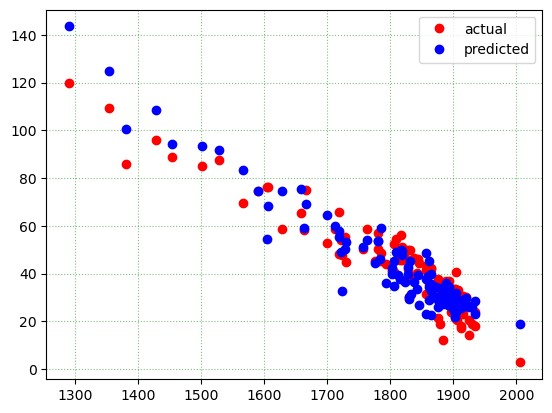

In [16]:
plt.plot(force1['Core Temp (F)'],force1['Meas FS (ksi)'],'ro',label='actual')
plt.plot(force1['Core Temp (F)'],force1['pred'],'bo', label='predicted')
plt.grid(color='g', ls=':', alpha=0.5)
plt.legend()
plt.show()